In [63]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm  
import matplotlib.pyplot as plt
import numpy as np

In [29]:
print("CUDA Disponible:", torch.cuda.is_available())
print("Nombre de GPU:", torch.cuda.device_count())
print("Nom du GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun GPU détecté")
print("Version CUDA:", torch.version.cuda)


CUDA Disponible: True
Nombre de GPU: 1
Nom du GPU: NVIDIA GeForce RTX 2060
Version CUDA: 11.8


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda


In [31]:
train_df = pd.read_csv("data/label_encoded_train_cleaned.csv")

X = train_df[["brand","model","milage","fuel_type","transmission","ext_col","int_col","accident","engine_hp","age"]].values
y = train_df["price"].values

In [32]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
X = scaler.fit_transform(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [35]:
print(len(X_train))
print(len(X_test))

112111
28028


In [36]:
print(X.shape, X_train.shape, X_test.shape)

(140139, 10) (112111, 10) (28028, 10)


In [37]:
print(y.shape, y_train.shape, y_test.shape)

(140139,) (112111,) (28028,)


In [38]:
class PricePredictionNN(nn.Module):
    def __init__(self):
        super(PricePredictionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X.shape[1], 2048),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)
    
model = PricePredictionNN().to(device)

In [39]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [40]:
epochs = 100
batch_size = 64
patience = 10 
best_loss = float('inf') 
early_stop_counter = 0 
best_model_state_dict = None  

In [41]:
for epoch in range(epochs):
    model.train()  # Met le modèle en mode entraînement
    epoch_loss = 0.0
    progress_bar = tqdm(range(0, len(X_train_tensor), batch_size), desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for i in progress_bar:
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())  # Afficher la loss en temps réel

    avg_epoch_loss = epoch_loss / len(progress_bar)  # Loss moyenne pour l'époque

    print(f"Epoch {epoch+1}/{epochs} - Loss moyenne: {avg_epoch_loss:.6f}")

    # Vérification de l'amélioration de la loss (early stopping)
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss  # Mise à jour de la meilleure perte
        early_stop_counter = 0  # Réinitialisation du compteur de patience
        best_model_state_dict = model.state_dict()  # Sauvegarder les poids du meilleur modèle
    else:
        early_stop_counter += 1  # Incrémenter le compteur de patience

    # Si patience est dépassée, arrêter l'entraînement
    if early_stop_counter >= patience:
        print(f"Early stopping déclenché après {epoch+1} époques.")
        break

# Charger les poids du meilleur modèle (le modèle avec la plus petite loss)
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print("Modèle restauré à partir du meilleur état.")

Epoch 1/100 - Loss moyenne: 857532255.662100


Epoch 2/100 - Loss moyenne: 367112422.904110


Epoch 3/100 - Loss moyenne: 224162723.013699


Epoch 4/100 - Loss moyenne: 187809458.041096


Epoch 5/100 - Loss moyenne: 181076511.470320


Epoch 6/100 - Loss moyenne: 177599647.150685


Epoch 7/100 - Loss moyenne: 174805334.045662


Epoch 8/100 - Loss moyenne: 172959676.351598


Epoch 9/100 - Loss moyenne: 172084206.367580


Epoch 10/100 - Loss moyenne: 171150076.917808


Epoch 11/100 - Loss moyenne: 170708640.246575


Epoch 12/100 - Loss moyenne: 170518575.390411


Epoch 13/100 - Loss moyenne: 169590551.121005


Epoch 14/100 - Loss moyenne: 169849638.289954


Epoch 15/100 - Loss moyenne: 169490569.993151


Epoch 16/100 - Loss moyenne: 169598630.264840


Epoch 17/100 - Loss moyenne: 169098823.945205


Epoch 18/100 - Loss moyenne: 169609998.623288


Epoch 19/100 - Loss moyenne: 169141846.621005


Epoch 20/100 - Loss moyenne: 169220873.351598


Epoch 21/100 - Loss moyenne: 169069132.691781


Epoch 22/100 - Loss moyenne: 168799921.899543


Epoch 23/100 - Loss moyenne: 169146750.175799


Epoch 24/100 - Loss moyenne: 168966692.974886


Epoch 25/100 - Loss moyenne: 168678253.799087


Epoch 26/100 - Loss moyenne: 168852411.376712


Epoch 27/100 - Loss moyenne: 168990387.146119


Epoch 28/100 - Loss moyenne: 169010105.136986


Epoch 29/100 - Loss moyenne: 168727196.107306


Epoch 30/100 - Loss moyenne: 168950512.299087


Epoch 31/100 - Loss moyenne: 168791789.728310


Epoch 32/100 - Loss moyenne: 168791618.239726


Epoch 33/100 - Loss moyenne: 168563224.751142


Epoch 34/100 - Loss moyenne: 168848179.296804


Epoch 35/100 - Loss moyenne: 168473068.447489


Epoch 36/100 - Loss moyenne: 168468743.821918


Epoch 37/100 - Loss moyenne: 168752550.013699


Epoch 38/100 - Loss moyenne: 168453656.949772


Epoch 39/100 - Loss moyenne: 168547167.698630


Epoch 40/100 - Loss moyenne: 168488617.874429


Epoch 41/100 - Loss moyenne: 168292705.630137


Epoch 42/100 - Loss moyenne: 168198713.178082


Epoch 43/100 - Loss moyenne: 168351507.792237


Epoch 44/100 - Loss moyenne: 168425658.739726


Epoch 45/100 - Loss moyenne: 168144792.751142


Epoch 46/100 - Loss moyenne: 168226288.013699


Epoch 47/100 - Loss moyenne: 168434315.901826


Epoch 48/100 - Loss moyenne: 168063328.769406


Epoch 49/100 - Loss moyenne: 168233597.573059


Epoch 50/100 - Loss moyenne: 168170492.152968


Epoch 51/100 - Loss moyenne: 167779465.410959


Epoch 52/100 - Loss moyenne: 167496994.125571


Epoch 53/100 - Loss moyenne: 168214033.947489


Epoch 54/100 - Loss moyenne: 167264127.031963


Epoch 55/100 - Loss moyenne: 167388221.643836


Epoch 56/100 - Loss moyenne: 167263893.018265


Epoch 57/100 - Loss moyenne: 167179004.789954


Epoch 58/100 - Loss moyenne: 167286044.853881


Epoch 59/100 - Loss moyenne: 167066765.006849


Epoch 60/100 - Loss moyenne: 167142954.020548


Epoch 61/100 - Loss moyenne: 166856321.317352


Epoch 62/100 - Loss moyenne: 166602835.728310


Epoch 63/100 - Loss moyenne: 166642004.100457


Epoch 64/100 - Loss moyenne: 166510248.385845


Epoch 65/100 - Loss moyenne: 166434824.454338


Epoch 66/100 - Loss moyenne: 166043526.938356


Epoch 67/100 - Loss moyenne: 166131225.799087


Epoch 68/100 - Loss moyenne: 166319936.917808


Epoch 69/100 - Loss moyenne: 166402295.235160


Epoch 70/100 - Loss moyenne: 166111123.593607


Epoch 71/100 - Loss moyenne: 165677141.203196


Epoch 72/100 - Loss moyenne: 165792255.796804


Epoch 73/100 - Loss moyenne: 165798971.442922


Epoch 74/100 - Loss moyenne: 165993145.182648


Epoch 75/100 - Loss moyenne: 165638702.500000


Epoch 76/100 - Loss moyenne: 165538923.123288


Epoch 77/100 - Loss moyenne: 165383681.187215


Epoch 78/100 - Loss moyenne: 165875026.118721


Epoch 79/100 - Loss moyenne: 165371307.826484


Epoch 80/100 - Loss moyenne: 165325796.815068


Epoch 81/100 - Loss moyenne: 165295493.152968


Epoch 82/100 - Loss moyenne: 165235959.152968


Epoch 83/100 - Loss moyenne: 165150896.751142


Epoch 84/100 - Loss moyenne: 165164819.335616


Epoch 85/100 - Loss moyenne: 165232258.821918


Epoch 86/100 - Loss moyenne: 165147727.767123


Epoch 87/100 - Loss moyenne: 164639892.696347


Epoch 88/100 - Loss moyenne: 164477414.141553


Epoch 89/100 - Loss moyenne: 164782794.171233


Epoch 90/100 - Loss moyenne: 164942984.166667


Epoch 91/100 - Loss moyenne: 164260369.068493


Epoch 92/100 - Loss moyenne: 164534006.794521


Epoch 93/100 - Loss moyenne: 164788718.783105


Epoch 94/100 - Loss moyenne: 164831371.086758


Epoch 95/100 - Loss moyenne: 164668029.257991


Epoch 96/100 - Loss moyenne: 164518481.847032


Epoch 97/100 - Loss moyenne: 165116460.712329


Epoch 98/100 - Loss moyenne: 164699538.586758


Epoch 99/100 - Loss moyenne: 164338544.100457


Epoch 100/100 - Loss moyenne: 164536739.860731
Modèle restauré à partir du meilleur état.


In [42]:
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

In [43]:
r2_train = r2_score(y_train, y_pred_train.cpu().numpy())
r2_test = r2_score(y_test, y_pred_test.cpu().numpy())

In [65]:
print(f"R² Train : {r2_train:.4f}")
print(f"R² Test : {r2_test:.4f}")

R² Train : 0.6331
R² Test : 0.6281


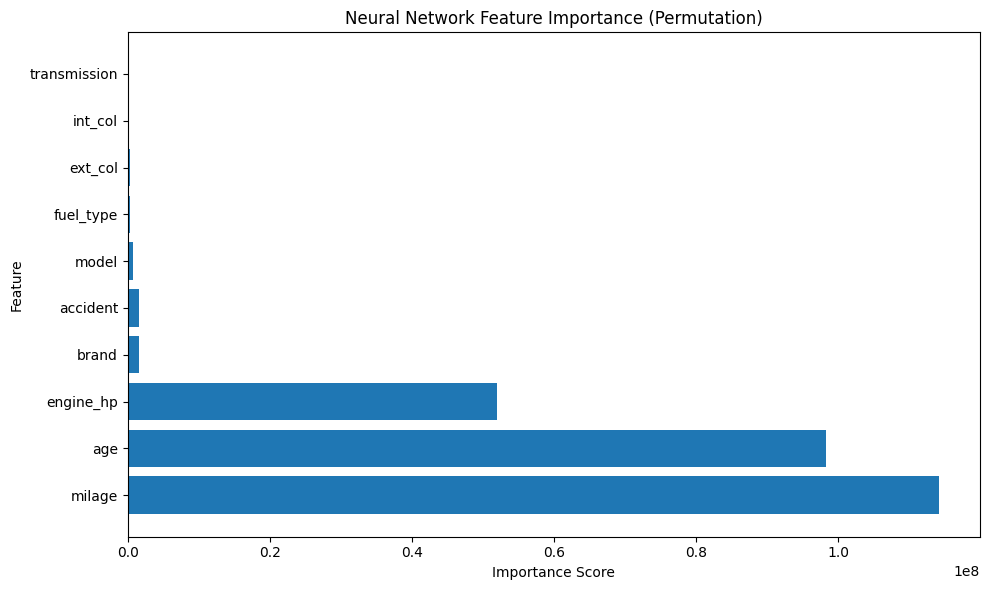

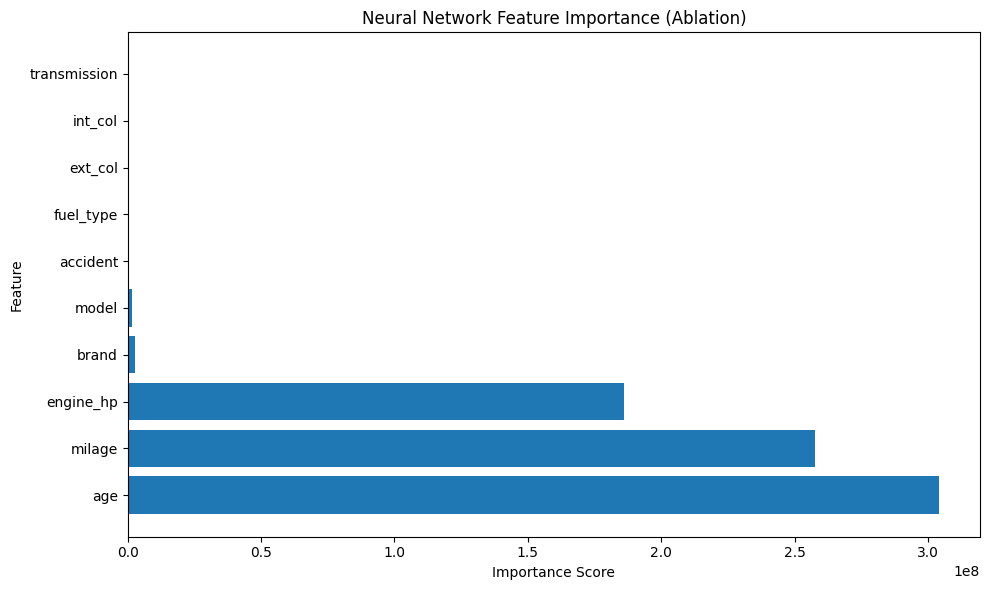

In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define your feature names
feature_names = ["brand", "model", "milage", "fuel_type", "transmission", 
                "ext_col", "int_col", "accident", "engine_hp", "age"]

# Method 1: Permutation Importance
def permutation_importance(model, X, y, feature_names, n_repeats=10):
    """Calculate feature importance using permutation importance."""
    model.eval()  # Set model to evaluation mode
    
    # Original prediction and loss
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
    
    with torch.no_grad():
        original_pred = model(X_tensor)
        original_loss = torch.nn.functional.mse_loss(original_pred, y_tensor).item()
    
    # Calculate importance for each feature
    importances = []
    for feature_idx in range(X.shape[1]):
        feature_importance = []
        
        for _ in range(n_repeats):
            # Create a copy of X and shuffle the feature
            X_permuted = X.copy()
            X_permuted[:, feature_idx] = np.random.permutation(X_permuted[:, feature_idx])
            
            # Convert to tensor and predict
            X_permuted_tensor = torch.tensor(X_permuted, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                permuted_pred = model(X_permuted_tensor)
                permuted_loss = torch.nn.functional.mse_loss(permuted_pred, y_tensor).item()
            
            # Importance is the increase in loss
            feature_importance.append(permuted_loss - original_loss)
            
        importances.append(np.mean(feature_importance))
    
    # Create a DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    return importance_df.sort_values('Importance', ascending=False)

# Method 2: Gradient-based feature importance
def gradient_importance(model, X, y, feature_names):
    """Calculate feature importance using input gradients."""
    model.train()  # Need gradients
    
    # Convert to tensors and require gradients
    X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
    
    # Forward pass
    pred = model(X_tensor)
    loss = torch.nn.functional.mse_loss(pred, y_tensor)
    
    # Backward pass
    loss.backward()
    
    # Get gradients with respect to inputs
    gradients = X_tensor.grad.abs().mean(dim=0).cpu().numpy()
    
    # Create a DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': gradients
    })
    
    return importance_df.sort_values('Importance', ascending=False)

# Method 3: Ablation analysis
def ablation_importance(model, X, y, feature_names):
    """Calculate feature importance by zeroing out features one by one."""
    model.eval()  # Set model to evaluation mode
    
    # Original prediction and loss
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
    
    with torch.no_grad():
        original_pred = model(X_tensor)
        original_loss = torch.nn.functional.mse_loss(original_pred, y_tensor).item()
    
    # Calculate importance for each feature
    importances = []
    for feature_idx in range(X.shape[1]):
        # Create a copy of X and zero out the feature
        X_ablated = X.copy()
        X_ablated[:, feature_idx] = 0  # Zero out feature
        
        # Convert to tensor and predict
        X_ablated_tensor = torch.tensor(X_ablated, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            ablated_pred = model(X_ablated_tensor)
            ablated_loss = torch.nn.functional.mse_loss(ablated_pred, y_tensor).item()
        
        # Importance is the increase in loss
        importances.append(ablated_loss - original_loss)
    
    # Create a DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    return importance_df.sort_values('Importance', ascending=False)

# Run the analyses
# Choose which method to use (you can run all three for comparison)
perm_importance = permutation_importance(model, X_test, y_test, feature_names)
# Skip the gradient-based method that's causing errors
# grad_importance = gradient_importance(model, X_test, y_test, feature_names)
abl_importance = ablation_importance(model, X_test, y_test, feature_names)

# Plotting function
def plot_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot the results
plot_importance(perm_importance, 'Neural Network Feature Importance (Permutation)')
plot_importance(abl_importance, 'Neural Network Feature Importance (Ablation)')